# CO2 Decision Trees (CART) and Information Gain 
## Prepared by: Rob Eugene A. Dequiñon and John Kenneth P. Alon

In this laboratory activity, we explored the foundational concepts behind Decision Trees, with a specific focus on the Classification and Regression Tree (CART) algorithm. Through hands-on implementation using Python, we analyzed how decision trees make data-driven decisions by calculating Entropy and Information Gain—two essential metrics that guide the splitting of datasets into more homogeneous subsets. Using the Balloon dataset, a simple categorical dataset, we traced the construction of a decision tree from scratch, identified the optimal attributes for splitting, and visualized the resulting tree structure. This activity provided practical insight into how decision trees classify data and reinforced key theoretical concepts with step-by-step computational examples.

### Pre-Lab Questions

#### 1. What is the main goal of a decision tree algorithm in classification?
The main goal of a decision tree in classification is to predict the class label of data instances by learning a series of rules based on feature values. It works by recursively partitioning the dataset using the attribute that results in the greatest reduction of impurity (measured by entropy), aiming to create pure or nearly pure subsets at the leaves.

#### 2. If a dataset subset contains an equal number of instances from two different classes, what would you expect its Entropy value to be (0, 0.5, or 1)? Why?
The entropy would be 1. This is because the class distribution is completely uncertain — both classes are equally probable, leading to maximum disorder or impurity. For binary classification, a 50-50 split yields the highest entropy value of 1.

#### 3. If splitting a dataset by attribute 'A' results in all subsets being perfectly pure, what would be the Information Gain for attribute 'A'?
The Information Gain would be equal to the entropy of the original set before the split. Since all subsets are perfectly pure (entropy = 0), the weighted average entropy after the split is 0. Thus, Information Gain = Entropy before split − 0 = Full Entropy of the parent node.

### Activity

In [71]:
#Imports
import numpy as np
import pandas as pd
from pprint import pprint

#For Tree Visualization
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt




In [72]:
# Load the dataset
df = pd.read_csv('balloon_dataset.csv')

# Display the first few rows
df.head()

,color,size,act,age,inflated
0,YELLOW,SMALL,STRETCH,ADULT,T
1,YELLOW,SMALL,STRETCH,ADULT,T
2,YELLOW,SMALL,DIP,ADULT,T
3,YELLOW,SMALL,DIP,CHILD,T
4,YELLOW,LARGE,STRETCH,ADULT,T


In [73]:
#Entropy function
def entropy(target_col):
    """
    Calculate the entropy of a dataset.
    The target_col is a list or pandas series of class labels (e.g., 'T', 'F').
    """
    elements, counts = np.unique(target_col, return_counts=True)
    entropy = 0
    for i in range(len(elements)):
        probability = counts[i] / np.sum(counts)
        entropy -= probability * np.log2(probability)
    return entropy

# Entropy of the full dataset
overall_entropy = entropy(df['inflated'])

print("Over All Entropy: ", overall_entropy)

Over All Entropy:  0.9886994082884974


In [74]:
# Information Gain function
def info_gain(data, split_attribute_name, target_name="inflated"):
    """
    Calculate the information gain of a dataset for an attribute.
    data: pandas DataFrame
    split_attribute_name: column name to split on
    target_name: name of the target variable
    """
    total_entropy = entropy(data[target_name])
    vals, counts = np.unique(data[split_attribute_name], return_counts=True)

    weighted_entropy = 0
    for i in range(len(vals)):
        subset = data[data[split_attribute_name] == vals[i]]
        weight = counts[i] / np.sum(counts)
        subset_entropy = entropy(subset[target_name])
        weighted_entropy += weight * subset_entropy

    return total_entropy - weighted_entropy

# Calculate information gain for all attributes
attributes = df.columns[:-1]  # exclude 'inflated'
gains = {attr: info_gain(df, attr) for attr in attributes}
gains

{'color': np.float64(0.10584334459644851),
 'size': np.float64(0.10584334459644851),
 'act': np.float64(0.10584334459644851),
 'age': np.float64(0.21330116100307883)}

In [75]:
# Find the attribute with the highest Information Gain
best_split = max(gains, key=gains.get)
best_split

'age'

In [76]:
# Decision Tree

def build_tree(data, features, target="inflated", depth=0, max_depth=None):
    """
    Recursively build a decision tree using Information Gain.
    """
    from collections import Counter

    labels = data[target]
    if len(np.unique(labels)) == 1:
        return np.unique(labels)[0]  # Pure leaf
    if len(features) == 0 or (max_depth is not None and depth >= max_depth):
        return Counter(labels).most_common(1)[0][0]  # Majority class

    gains = [info_gain(data, feature, target) for feature in features]
    best_feature = features[np.argmax(gains)]

    tree = {best_feature: {}}
    for value in np.unique(data[best_feature]):
        sub_data = data[data[best_feature] == value]
        subtree = build_tree(
            sub_data, [f for f in features if f != best_feature],
            target, depth + 1, max_depth
        )
        tree[best_feature][value] = subtree

    return tree

# Build the full decision tree
tree = build_tree(df, list(attributes))
tree


{'age': {'ADULT': {'act': {'DIP': {'color': {'PURPLE': 'F',
      'YELLOW': {'size': {'LARGE': 'F', 'SMALL': 'T'}}}},
    'STRETCH': 'T'}},
  'CHILD': {'color': {'PURPLE': 'F',
    'YELLOW': {'size': {'LARGE': 'F', 'SMALL': 'T'}}}}}}

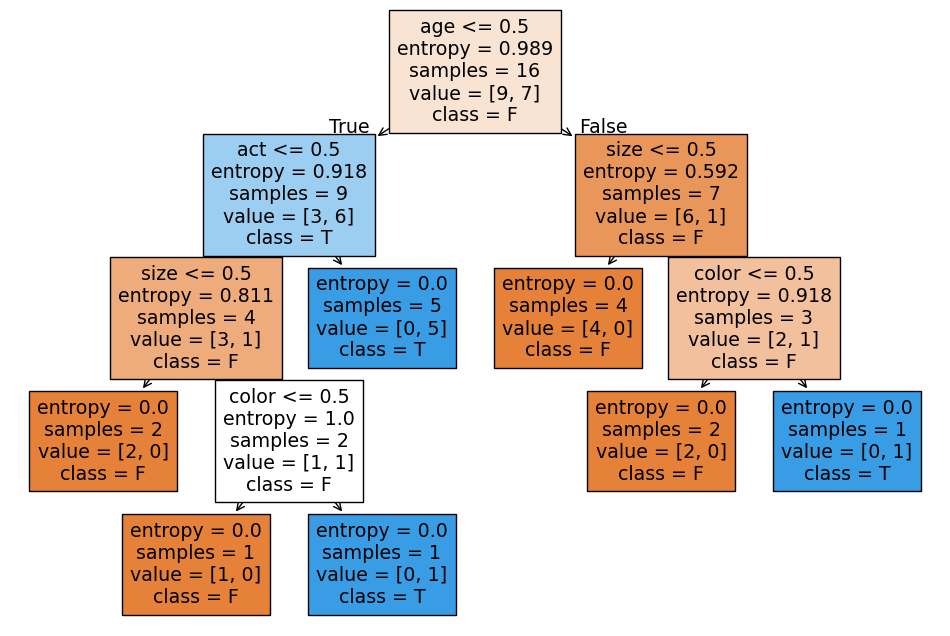

In [77]:
# Copy the dataframe to avoid modifying the original
df_print = df.copy()
le_dict = {}
for col in df_print.columns:
    le = LabelEncoder()
    df_print[col] = le.fit_transform(df_print[col])
    le_dict[col] = le

# Separate features and target
X = df_print.drop('inflated', axis=1)
y = df_print['inflated']

# Fit the Decision Tree
clf = DecisionTreeClassifier(criterion='entropy', random_state=42)
clf.fit(X, y)

# Plot the tree
plt.figure(figsize=(12,8))
plot_tree(clf, feature_names=X.columns, class_names=le_dict['inflated'].classes_, filled=True)
plt.show()

In [78]:
# Limit the maximum depth of the tree
tree_limited = build_tree(df, list(attributes), max_depth=2)
pprint(tree_limited)

{'age': {'ADULT': {'act': {'DIP': 'F', 'STRETCH': 'T'}},
         'CHILD': {'color': {'PURPLE': 'F', 'YELLOW': 'F'}}}}


In [79]:
# Use the trained sklearn DecisionTreeClassifier to predict on the dataset
predictions = clf.predict(X)

# Add predictions to the DataFrame for comparison
results = df.copy()
results['predicted_inflated'] = le_dict['inflated'].inverse_transform(predictions)

# Display the first few rows with predictions
results.head()

,color,size,act,age,inflated,predicted_inflated
0,YELLOW,SMALL,STRETCH,ADULT,T,T
1,YELLOW,SMALL,STRETCH,ADULT,T,T
2,YELLOW,SMALL,DIP,ADULT,T,T
3,YELLOW,SMALL,DIP,CHILD,T,T
4,YELLOW,LARGE,STRETCH,ADULT,T,T
